# Costos de seguros médicos en EE. UU.
## Introducción
Este proyecto tiene como objetivo el análisis de datos de los costos de los seguros médicos en EE. UU. y la predicción de estos costos utilizando modelos de machine learning. El análisis se enfoca en la detección de patrones y/o relaciones entre diferentes grupos de la población que permitan establecer la influencia de cada factor en el cálculo o asignación del valor de la asistencia médica identificando las diferencias entre sexos.

El conjunto de datos incluye las siguientes variables:

- Edad: Edad en años
- Sexo: Género, "masculino" o "femenino"
- IMC: Índice de masa corporal, calculado como el peso (en kg) dividido por la altura (en metros) al cuadrado
- Hijos: Cantidad de hijos
- Fumador: Condición de fumadoro no
- Región: Región de residencia, "noreste", "noroeste", "sureste" o "suroeste"
- Cargos: Costo de la asitencia médica

## Análisis exploratorio de datos

In [14]:
#importar librerias 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=RuntimeWarning)

In [15]:
#Importar conjunto de datos
data = pd.read_csv('/kaggle/input/medical-insurance-costs/insurance.csv')
df = data.copy()

El conjunto de datos contiene la información descrita anteriormente de 1338 usuarios y no presenta datos nulos.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


El resumen estadístico de las variables cuantitativas del conjunto de datos, permite establecer que el rango de edad de aquellos quienes adquirieron el seguro de atención médica se encuentra entre 18 y 64 años. Asi mismo, 5 es el número máximo de hijos de los clientes de esta compañía. El índice de masa corporal de sus clientes se encuentra entre 15.96 y 53.13, y los importes asignados por la compañía oscilan entre US 1121.8 y US 63770.4, con una media de US 13270.4 y desviación estandard de US 12110.

In [17]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Respecto de las variables cualitativas, el valor más frecuente para 'sex' es 'male' con una frecuencia de 676 y 'southeast' para la region de residencia con un total de 364 registros. Por otro lado, del total de registros para la cateogoría 'smoker', la opción 'no' es la de mayor preponderancia. 1064 clientes de la compañía son no fumadores.

In [18]:
df.describe(include = ['O'])

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


A partir del análisis de correlación entre variables, se identifican la edad, el indice de masa corporal y la condición de fumador o no, siendo esta última la que presenta mayor correlación, como las variables con mayor influencia sobre el cálculo  de la asignación de los costos de la asistencia médica para los clientes de la compañía. Es decir, al estimar los costos del seguro médico, la valoración de las paricularidades específicas de los clientes en estos componentes prima sobre el sexo, la región o el número de hijos.

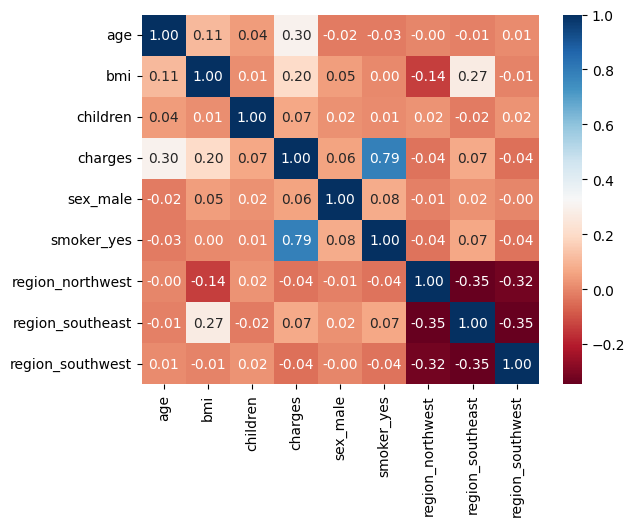

In [19]:
#correlación entre variables 
df_corr = data.copy()
df_corr_dum = pd.get_dummies(df_corr, drop_first = True)
sns.heatmap(df_corr_dum.corr(), annot=True,cmap = 'RdBu', fmt = '.02f')
plt.show()

Sobre la base de los resultados del análisis de correlación entre variables, se crean las variables 'bmi_group' y 'age_group' para agrupar y clasificar el índice de masa corporal y la edad según la estratificación por categorías, para facilitar el análisis de los costos de la asistencia médica.

In [20]:
#Grupos etarios
age_bins = [0,25,40,55,75]
age_labels =['young people','young adults','adults','older adults']
df['age_group'] = pd.cut(df.age, bins=age_bins, right = True, labels = age_labels)
#grupos BMI
bmi_bins = [0,18.5,25,30,35,40,60]
bmi_labels = ['underweight','normal weight','overweight','obesity class 1','obesity class 2','obesity class 3']
df['bmi_group'] = pd.cut(df.bmi, bins=bmi_bins, labels =bmi_labels)

In [21]:
df = df.drop(columns={'age','bmi'})
df.columns

Index(['sex', 'children', 'smoker', 'region', 'charges', 'age_group',
       'bmi_group'],
      dtype='object')

En relación a la distribución de los costos asociados a la asistencia médica de los clientes de la compañía, se establece que los costos presentan un distribución unimodal sesgada hacia la derecha. Es decir,es su mayoría, los clientes pagan un importe por concepto de asistencia médica, ubicado en el extremo izquierdo o inferior de los costos reportados por la compañía. En este sentido, el valor medio de los costos se ve afectado por los valores atípicos de la asistencia asignada a algunos usuarios debido a sus caracteristicas particulares. Por lo tanto, el análisis de costos se realiza de acuerdo al valor de la mediana, valor más cercano a la realidad y que se ve menos afectado por la presencia de valores atípicos.

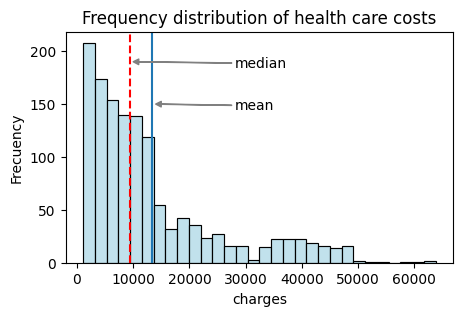

In [22]:
#Gráfica de la disribución de frecuencia de los costos de asistencia medica
fix, ax = plt.subplots(figsize=(5,3))
sns.histplot(df['charges'],color='lightblue')
ax.set_title('Frequency distribution of health care costs')
plt.axvline(x = np.mean(df['charges']))
plt.axvline(x = np.median(df['charges']), color= 'r', ls='--')
plt.annotate(text = 'median', xy=(10000, 190), xytext =(28000,185), arrowprops=dict(color='gray',width=0.2, headwidth=4, headlength=4))
plt.annotate(text = 'mean', xy=(14000, 150), xytext =(28000,145), arrowprops=dict(color='gray',width=0.2, headwidth=4, headlength=4))
ax.set_ylabel('Frecuency')
plt.show()

### Análisis del costo de la asistencia médica

El costo medio del seguro medico para hombres y mujeres es de: 9412.96 y 9369.62 respectivamente. En general, las mujeres pagan 43.35 dolares más por su atención medica.

In [23]:
proportion_sex = round(df['sex'].value_counts(normalize=True)*100,2)
print(f'La proporción de clientes hombres es de  {proportion_sex.values[0]}% y mujeres de {proportion_sex.values[1]}%')

mean_cost_sex = df.groupby('sex', as_index=False)['charges'].median()
print('El costo medio de la atención medica para mujeres es de: {:0.2f}'.format(mean_cost_sex['charges'][0]),'dolares.')
print('El costo medio de la atención medica para hombres es de: {:0.2f}'.format(mean_cost_sex['charges'][1]),'dolares.')

diff_sex = mean_cost_sex['charges'][0] - mean_cost_sex['charges'][1]
print('La diferencia entre el costo de asistencia medica entre mujeres y hombres es: {:0.2f}'.format(diff_sex),'dolares.')

La proporción de clientes hombres es de  50.52% y mujeres de 49.48%
El costo medio de la atención medica para mujeres es de: 9412.96 dolares.
El costo medio de la atención medica para hombres es de: 9369.62 dolares.
La diferencia entre el costo de asistencia medica entre mujeres y hombres es: 43.35 dolares.


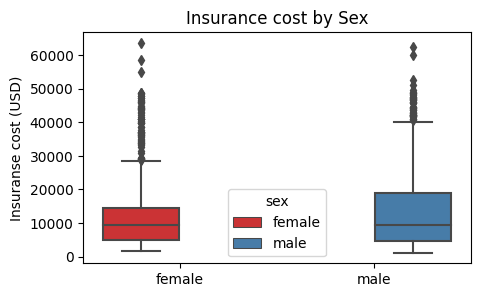

In [24]:
fig, ax = plt.subplots(figsize =(5,3))
sns.boxplot( x='sex',y='charges',hue='sex', data = df, ax=ax, palette='Set1')
ax.set_ylabel('Insuranse cost (USD)')
ax.set_title('Insurance cost by Sex')
ax.set_xlabel('')
plt.show()

Siguiendo la misma lógica, se contruyen funciones que permitan establecer la proporción de clientes y costo de la asistencia médica para cada categoría. Asi mismo, se contruye una función para graficar la distribución por categoría de los costos asociados al seguro.

In [25]:
#Calcula la proporción de clientes por grupos para las categorías 'col1' y 'col2'
def clients_proportions_groups(col1,col2,df):
    proportions = round(df.groupby([col1,col2])[col1].count() / len(df) *100,2)
    print(f'La proporción de clientes por grupos para las categorías {col1} y {col2} es:\n {proportions}')

    
#Calcula el costo de la asistencia medica entre grupos de dos categorías 'col1' y 'col2'
def insurance_cost_groups(col1, col2, df):
    cost = round(df.groupby([col1,col2], as_index=False)['charges'].median(),2).sort_values(by='charges', ascending=False)
    cost.set_index(col1, inplace=True)
    print(f'El costo medio en dolares de la asistencia medica para las categorías  {col2} y {col1} por grupos es de: \n  {cost}.')

#Gráfica la distribución del costo de la asistencia médica entre grupo de dos categorías
def plot_insurance_cost_groups(col1,col2,df):
    fig, ax = plt.subplots(figsize=(10,3))
    sns.boxplot(x=col1 ,y='charges', data= df, hue=col2, palette='Set1')
    ax.set_title(f'Insurance cost by groups: {col1} - {col2} ')
    ax.set_ylabel('Insuranse cost (USD)')
    ax.set_xlabel('')
    plt.show()

### Costo de asistencia - comparativa por categorías

Como se mencionó inicialmente, el análisis de los costos de la asistencia médica para los clientes de la compañía busca establecer diferencia entre los costos asignados por sexo. Sobre esta base, se realiza la comparativa entre cada una de la categoriás contempladas en el conjunto de datos y la variación en la asignación de los costos para cada sexo.

### grupo BMI - sexo
Para el grupo BMI - sexo, se establece que al rededor del 60% de los clientes se encuentran en las categorías de sobrepeso u obesidad clase 1, un poco más de 30% con una distribución equivalente para peso normal u obesidad clase 2, menos del 2% para bajo peso y casi un 7% para obesidad clase 3. En general, la proporción entre hombres y mujeres en cada categoría es similar con diferecias cercanas al 1%.

In [26]:
clients_proportions_groups('bmi_group','sex',df)

La proporción de clientes por grupos para las categorías bmi_group y sex es:
 bmi_group        sex   
underweight      female     0.97
                 male       0.60
normal weight    female     8.82
                 male       8.07
overweight       female    14.72
                 male      14.13
obesity class 1  female    13.98
                 male      15.10
obesity class 2  female     8.00
                 male       8.82
obesity class 3  female     2.99
                 male       3.81
Name: bmi_group, dtype: float64


En lo referente a los costos de la asistencia médica, para ambos sexos, los clientes con obesidad clase 2 presentan los costos más elevados. Mujeres con peso bajo o normal, pagan más que los hombres. En particular, en el rango de peso bajo es muy notoria la diferencia entre mujeres y hombres(US 5600). Sin embargo, a medida que el indice de masa corporal se incrementa, los costos para mujeres se mantienen en un rango estrecho con variaciones entre US 200 y US 300, salvo para el caso de obesidad clase 2 donde la diferencia con la condición anterior es de aporximadamente US 1600. En el caso de los hombres, entre peso bajo y normal hay un salto de aproximadamente US 4000 y de US 1200 para sobrepeso en el costo de la asistencia médica. En adelante los costos médicos en promedio, siguen un comportamiento similar al presentado para las mujeres. Sin embargo, es evidente que los costos del seguro médico que paga la población masculina presenta mayor variabilidad.

In [27]:
insurance_cost_groups('bmi_group','sex',df)

El costo medio en dolares de la asistencia medica para las categorías  sex y bmi_group por grupos es de: 
                      sex   charges
bmi_group                        
obesity class 2    male  11364.62
obesity class 2  female  10959.69
obesity class 3    male   9748.91
obesity class 3  female   9675.23
underweight      female   9644.25
obesity class 1    male   9596.71
obesity class 1  female   9414.92
normal weight    female   9229.32
overweight         male   9225.26
overweight       female   8277.52
normal weight      male   7914.62
underweight        male   3945.85.


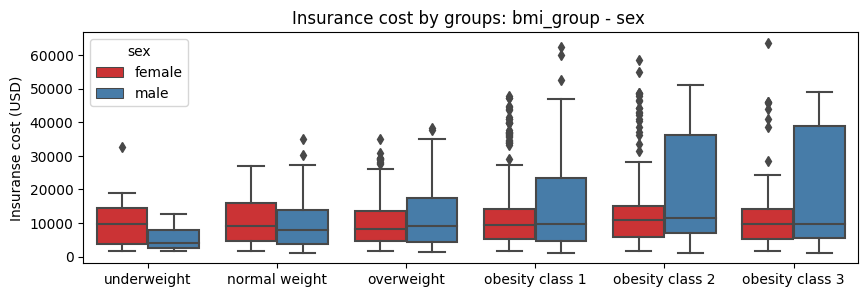

In [28]:
plot_insurance_cost_groups('bmi_group','sex',df)

### Grupo etario - sexo
La distribución de grupos etarios por sexo es similar con diferencias inferiores al 1% en todos los casos.

In [29]:
clients_proportions_groups('age_group','sex',df)

La proporción de clientes por grupos para las categorías age_group y sex es:
 age_group     sex   
young people  female    10.99
              male      11.88
young adults  female    14.50
              male      15.02
adults        female    15.77
              male      15.70
older adults  female     8.22
              male       7.92
Name: age_group, dtype: float64


En relación a los costos asociados a la asistencia médica, se puede inferir que a mayor edad, mayor es el costo de los servicios en salud. Es decir la edad y los costos tienen una relación directamente proporcional. De nuevo, es clara la mayor variabilidad en la asignación de costos para la población masculina.

In [30]:
insurance_cost_groups('age_group','sex',df)

El costo medio en dolares de la asistencia medica para las categorías  sex y age_group por grupos es de: 
                   sex   charges
age_group                     
older adults  female  13539.11
older adults    male  13136.47
adults        female  10156.78
adults          male   9819.65
young adults    male   6059.17
young adults  female   5640.09
young people  female   2801.26
young people    male   2304.00.


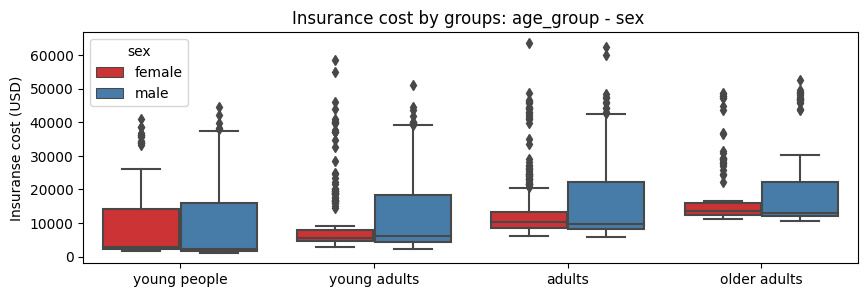

In [31]:
plot_insurance_cost_groups('age_group','sex',df)

###  Número de hijos - sexo
La distribución entre hombres y mujeres en cuanto al número de hijos se encuentra balanceada, es decir comparten en ambos casos proporciones similares. En su mayoría, aproximadamente el 60% de los clientes de la compañia, tienen 1 o no tienen hijos. Esta proporción disminuye a medida que aumenta en número de hijos.  

In [32]:
clients_proportions_groups('children','sex',df)

La proporción de clientes por grupos para las categorías children y sex es:
 children  sex   
0         female    21.60
          male      21.30
1         female    11.81
          male      12.41
2         female     8.89
          male       9.04
3         female     5.75
          male       5.98
4         female     0.82
          male       1.05
5         female     0.60
          male       0.75
Name: children, dtype: float64


En cuanto a los costos, se aprecian valores más elevados para la atención en salud de clientes con tres y cuatro hijos. No hay evidencia que un mayor número de hijos incremente los costos. 

Excepto para la categoría de 5 hijos, donde los costos son más bajos, es más amplia la variación entre los costos asociados a la atención medica para los hombres que para mujeres.

In [33]:
insurance_cost_groups('children','sex',df)

El costo medio en dolares de la asistencia medica para las categorías  sex y children por grupos es de: 
               sex   charges
children                  
4           male  11128.49
3         female  11085.59
4         female  11033.66
3           male  10414.98
0           male  10214.64
2         female  10107.22
0         female   9541.70
5         female   8781.31
1           male   8734.35
2           male   8603.82
1         female   8232.87
5           male   6732.85.


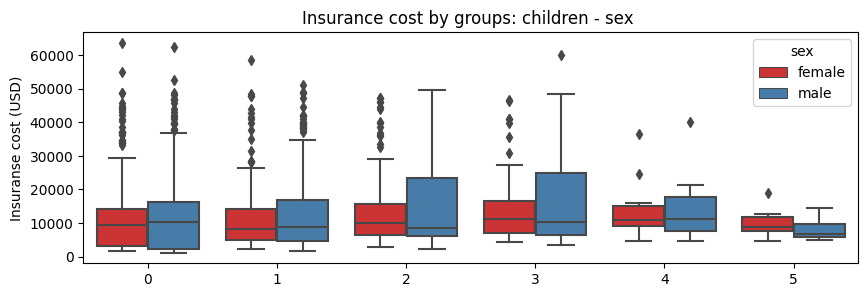

In [34]:
plot_insurance_cost_groups('children','sex',df)

### Fumadores - sexo
En relación a grupo fumadores - sexo, aproximadamente del 80% de los clientes de la compañia son no fumadores. El porcentaje restante, que incluye a los clientes fumadores, esta conformado por un 8.6% de mujeres y un 11.9% de hombres.

In [35]:
clients_proportions_groups('smoker','sex',df)

La proporción de clientes por grupos para las categorías smoker y sex es:
 smoker  sex   
no      female    40.88
        male      38.64
yes     female     8.59
        male      11.88
Name: smoker, dtype: float64


Los costos de atención en salud se ven fuertemente influenciados por esta condición. Los costos para no fumadores presentan un valor medio de US 8000 aproximadamente y más de US 30000 para fumadores.

In [36]:
insurance_cost_groups('smoker','sex',df)

El costo medio en dolares de la asistencia medica para las categorías  sex y smoker por grupos es de: 
             sex   charges
smoker                  
yes       male  36085.22
yes     female  28950.47
no      female   7639.42
no        male   6985.51.


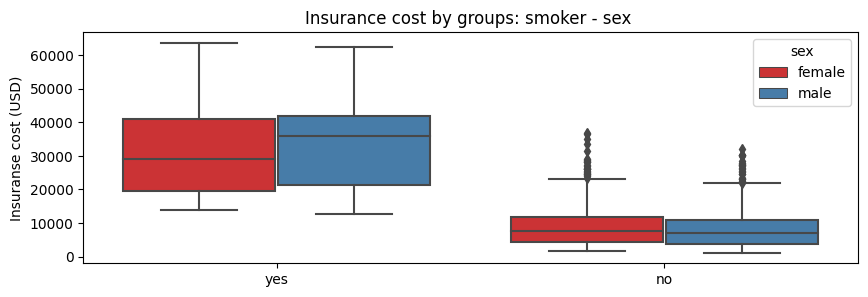

In [37]:
plot_insurance_cost_groups('smoker','sex',df)

### Region - sexo
Respecto a las diferencias en distribución de clientes por regiones para cada sexo, se puede establecer que la proporción, en ambos casos, es similar con diferencias mínimas. La región sudeste, presenta la mayor proporción de usuarios, con una diferencia inferior a un punto en comparación con las otras regiones.

In [38]:
clients_proportions_groups('region','sex',df)

La proporción de clientes por grupos para las categorías region y sex es:
 region     sex   
northeast  female    12.03
           male      12.18
northwest  female    12.26
           male      12.03
southeast  female    13.08
           male      14.13
southwest  female    12.11
           male      12.18
Name: region, dtype: float64


En relación a los costos de asistencia médica discriminado por regiones, se establece que en la región norte los costos son más elevado, excepto para los hombres de la región noreste donde los costos son menores en comparación con las otras regiones. Así mismo, es más costosa la atención en salud para los clientes ubicados en la zona este. Por otro lado, el valor medio de los costos asignados a mujeres en la región sur es menor que para los hombres, y esto ocurre de forma inversa en el norte, donde los mujeres asumen costos más elevados.

In [39]:
insurance_cost_groups('region','sex',df)

El costo medio en dolares de la asistencia medica para las categorías  sex y region por grupos es de: 
                sex   charges
region                     
northeast  female  10197.77
northeast    male   9957.72
northwest  female   9614.07
southeast    male   9504.31
southwest    male   9391.35
southeast  female   8582.30
southwest  female   8530.84
northwest    male   8413.46.


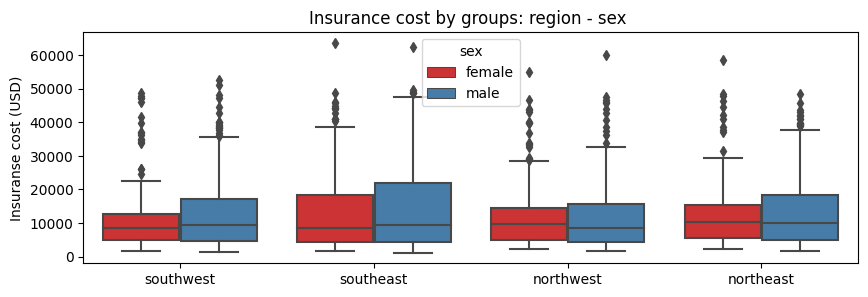

In [40]:
plot_insurance_cost_groups('region','sex',df)

En terminos generales, el componente que influye en mayor medida sobre la asignación de costos de asistencia médica es el asociado a la condición de fumador o no, seguido de la edad y el indice de masa corporal. La distribución sesgada de los costos y la presencia de gran cantidad de valores atípicos se atribuyen al resultado de la suma de multiples condiciones especiales en los clientes de la compañía, a saber, un usuario de edad elevada, fumador y con sobrepeso será considerado como un usuario que requerira de mayor cobertura médica en comparación con una persona joven, de peso normal y no fumador. No se evidencian diferencias marcadas en los costos promedio para hombres y mujeres, salvo para los fumadores. Sin embargo, hay mayor variabilidad en los costos para los hombres. En la mayoría de las categorías, las dispersión de los valores, hacia el límite superior, es mayor en comparación con los costos para las mujeres.

## Modelo para predecir el costo de asistencia medica

Para la predicción de los costos asociados a la asistencia médica de los clientes de la compañía, se entrenan tres modelos de machine learning: regresión lineal, regresor de arbol de decisión y regresor de bosque aleatorio y se evalua la capacidad de cada modelo para explicar su variabilidad frente a la predicción de los costos y la diferencia promedio de estas predicciones frente a los valores reales.

In [41]:
#definir variables: dependiente e independientes
X=df_corr_dum.drop('charges', axis=1)
y = df_corr_dum.charges

In [49]:
#Creación conjuntos de entrenamiento para validación cruzada
X_trainval, X_test, y_trainval, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

models = [
    ('LinearRegression', LinearRegression()),
    ('DecisionTree', DecisionTreeRegressor()),
    ('RandomForest', RandomForestRegressor())
]

for name, model in models:
    scores = cross_val_score(model, X_trainval, y_trainval, cv=5, scoring='r2')  # 5-fold CV
    print(f'{name}: R² promedio = {np.mean(scores):.3f}, desvío = {np.std(scores):.3f}')

LinearRegression: R² promedio = 0.730, desvío = 0.021
DecisionTree: R² promedio = 0.689, desvío = 0.023
RandomForest: R² promedio = 0.812, desvío = 0.028


De acuerdo a los resultados de la validación cruzada, el regresor de bosque aleatorio es el modelo que mejor captura las interaciones complejas entre las variables y su relación con la estimación del costo de la asistencia médica. El modelo explica la variabilidad de gran parte de la datos, con un coeficiente de determinación promedio [R²]  = 0.811.

In [50]:
#Entrenamiento del modelo final con el conjunto X_trainval -y_trainval
model = RandomForestRegressor()
model.fit(X_trainval, y_trainval)
y_pred= model.predict(X_test)
print(f"R² (test): {r2_score(y_test, y_pred):.3f}")
print(f"RMSE (test): {mean_squared_error(y_test, y_pred, squared=False):.2f}")

R² (test): 0.879
RMSE (test): 4386.44


Una vez seleccionado el modelo con mejor desempeño en la validación cruzada y entrenado nuevamente con el conjunto completo de entrenamiento, se encontró que el regresor de bosque aleatorio es capaz de explicar el 87.9% de la variabilidad en los datos. Además, de acuerdo con el valor del RMSE obtenido en el conjunto de prueba, se estima que las predicciones del modelo sobre el costo medio de la asistencia médica pueden diferir en promedio en 4378.8 dólares respecto al valor real.

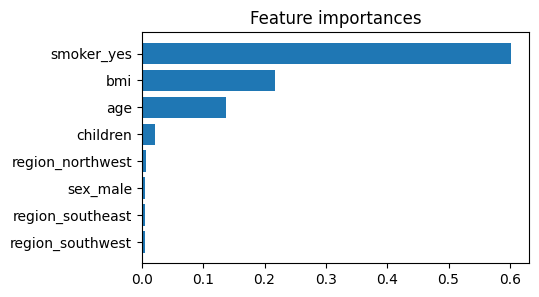

In [51]:
#Importancia de características
importances = model.feature_importances_
indices = np.argsort(importances)

importances_dict = dict(zip(X_trainval.columns[indices] , np.array(importances)[indices]))

#Gráfica importancia de características
fig, ax = plt.subplots(figsize=(5,3))
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_trainval.columns)[indices])
ax.set_title('Feature importances')
plt.show()

De acuerdo al análisis de la importancia de las caractísticas en el rendimiento del modelo, se establecen la condición de fumador, seguida del indice de masa corporal y la edad, como las variables más influeyentes en la asignación de los costos de la asistencia medica para los clientes de la compañía. 

Finalmente, si bien el modelo captura las interacciones entre variables, interpreta gran parte de la variabilidad y presenta el error más bajo entre valores reales y predicciones. Dada la complejidad de las relaciones en datos asociados a temas de salud, el modelo podría constituir una buena aproximación para la estimación de los costos de los servicios en salud proporcionados por la compañía. Sin embargo, en aras de mejorar la capacidad de generalización del modelo y la captura de relaciones complejas entre las variables, para posteriores análisis se sugiere un análisis de hiperparametros.